In [1]:
import pandas as pd
import seaborn as sbs
import sqlite3 as sql
import sklearn as sk

This analysis aims to understand the different regions the bank operates in.

1. Data cleaning
2. Trends of different variables
3. Finding correlations
4. Feature engineering
5. Dimensionality reduction
6. Clustering

In [2]:
districts = None
with sql.connect("../database_test.db") as conn:
    districts = pd.read_sql("select * from districts", conn)
districts
# prague is a gigantic outlier in most regards, so we will remove it for this analysis
districts = districts.drop(0)
districts

,id,name,region,no_inhabitants,no_small_places,no_medium_places,no_large_places,no_very_large_places,no_cities,ratio_urban_inhabitants,avg_salary,unemployment_95,unemployment_96,entrepreneur_ratio,crimes_95,crimes_96
1,2,benesov,central bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132.0,2159.0,2674
2,3,beroun,central bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111.0,2824.0,2813
3,4,kladno,central bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109.0,5244.0,5892
4,5,kolin,central bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118.0,2616.0,3040
5,6,kutna hora,central bohemia,77963,60,23,4,2,4,51.5,8546,2.95,4.02,126.0,2640.0,3120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,opava,north moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90.0,4355.0,4433
73,74,ostrava - mesto,north moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100.0,18782.0,18347
74,75,prerov,north moravia,138032,67,30,4,2,5,64.6,8819,5.38,5.66,99.0,4063.0,4505
75,76,sumperk,north moravia,127369,31,32,13,2,7,51.2,8369,4.73,5.88,107.0,3736.0,2807


In [3]:
label_data = districts[["id", "name", "region"]]
numerical_data = districts.drop(columns=["id", "name", "region"])

In [4]:
# Data cleaning. Sometimes we do not have numbers for unemployment or crimes for a given year.
# Furthermore it is not so relevant to analyse the year on year stats, so we are better off calculating the average and assuming
# that if a year is missing data, we can just use the data from the other year by itself
# Crime and unemployment for '95 have missing data

numerical_data.unemployment_95 = numerical_data.unemployment_95.fillna(numerical_data.unemployment_96)
numerical_data = numerical_data.assign(
    unemployment = [
        (u95 + u96) / 2 for u95, u96 in zip(numerical_data.unemployment_95, numerical_data.unemployment_96)
    ]
).drop(columns=["unemployment_95", "unemployment_96"])
numerical_data.columns

numerical_data.crimes_95 = numerical_data.crimes_95.fillna(numerical_data.crimes_96)
numerical_data = numerical_data.assign(
    crimes = [
        (c95 + c96) / 2 for c95, c96 in zip(numerical_data.crimes_95, numerical_data.crimes_96)
    ]
).drop(columns=["crimes_95", "crimes_96"])
numerical_data.columns

Index(['no_inhabitants', 'no_small_places', 'no_medium_places',
       'no_large_places', 'no_very_large_places', 'no_cities',
       'ratio_urban_inhabitants', 'avg_salary', 'entrepreneur_ratio',
       'unemployment', 'crimes'],
      dtype='object')

<AxesSubplot:>

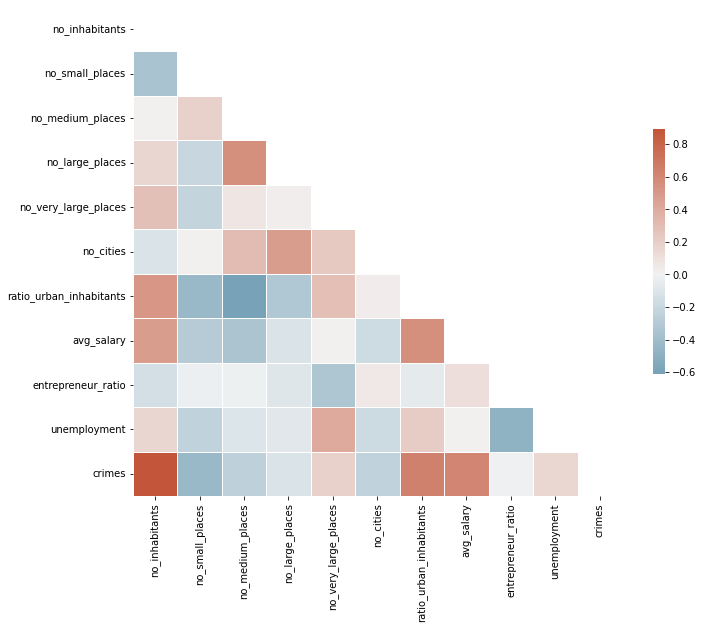

In [5]:
# Now let's examine the correlation matrix between the different variables:
import numpy as np
import matplotlib.pyplot as plt
# Compute the correlation matrix
corr = numerical_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sbs.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sbs.heatmap(corr,  mask=mask,cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

According to the table above, we can see that several features are severely correlated amongst each other.
Because, generally speaking, analysis becomes easier if we consider fewer features, we will move on to performing dimensionality reduction, using Principal Component Analysis.
We use PCA to determine a new base for our feature space, which consists of base vectors that we call Principal Components, that has the characteristic that, when we project our data set onto it, a maximum amount of the data's variance is preserved with a minimum number of dimensions.

In [6]:
from sklearn.decomposition import PCA

# We need to first scale the data to a normalized standard because, otherwise, the components
# would be nominated by the dimensions that have the larger order of magnitude (i.e. population)
from sklearn.preprocessing import StandardScaler
x = numerical_data.values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
scaled_data = pd.DataFrame(x_scaled, columns=numerical_data.columns)

pca = PCA()
pca.fit(scaled_data)
pca.explained_variance_ratio_


array([0.32207663, 0.18609738, 0.15040436, 0.09896732, 0.07403734,
       0.05758405, 0.04189072, 0.03474222, 0.02061771, 0.01049937,
       0.0030829 ])

In [7]:
# from observing these results we can see that if we
# keep 4 dimensions we keep over 75% of the original variance
pca = PCA(n_components=4)
base_shifted_data = pca.fit_transform(scaled_data)
pca.components_

array([[ 0.40092915, -0.29985419, -0.27600222, -0.13603364,  0.17525933,
        -0.14267338,  0.45165411,  0.37614486, -0.06828035,  0.18633733,
         0.46768491],
       [ 0.23867716, -0.19627247,  0.41955472,  0.51154719,  0.40564934,
         0.3719798 , -0.0556777 , -0.12052551, -0.30337241,  0.22892446,
         0.04261044],
       [ 0.21530102, -0.13864416,  0.18728489,  0.33394088, -0.284975  ,
         0.23546777,  0.00075767,  0.25333108,  0.51161635, -0.53543197,
         0.19636551],
       [-0.33539047, -0.15385248, -0.35433445, -0.09675974,  0.29198955,
         0.62645748,  0.38572426, -0.03620455,  0.17726962, -0.09653853,
        -0.245728  ]])

Interpreting the components:
 1. The first component suggests that districts with higher population tend to have more crimes, a larger urban population, and a higher average salary. Futhermore, the negative correlation with the number of places with small to to medium population suggests that more populated districts tend to have fewer, but higher population places, such as large cities and their suburbs, in detriment of villages and smaller towns.
 2. The second component suggests that districts with less entreprenours tend to have more unemployment. Furthermore, there is a correlation with the number of very large settlements, but we could not find the relevant correlation.
 3. The third component tells us that places with medium population tend to have a large amount of smaller cities, as well as relatively lower unemployment that average. This might imply a cluster of districts with a lot of smaller, but productive areas.
 4. We had difficulties interpreting the correlations of the fourth component.

Clustering

Now we will try to apply clustering techniques to the data and invert the transformations, as well as interpret the results of the clustering.

<AxesSubplot:xlabel='n_clusters', ylabel='inertia'>

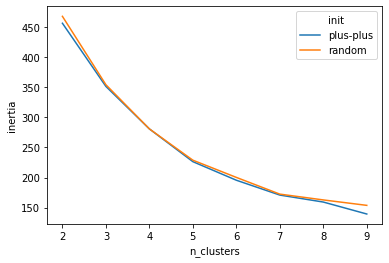

In [8]:
from sklearn.cluster import KMeans

n_cluster_candidates = list(range(2, 10))
kmeans_sets = pd.DataFrame(columns=["init", "n_clusters", "inertia"])

for n_clusters in n_cluster_candidates:
    km = KMeans(
        n_clusters=n_clusters,
        random_state=19,
    )
    km.fit(base_shifted_data)
    kmeans_sets = kmeans_sets.append({"init": "plus-plus", "n_clusters": n_clusters, "inertia": km.inertia_}, ignore_index=True)
    
    km = KMeans(
        n_clusters=n_clusters,
        init="random",
        random_state=19,
    )
    km.fit(base_shifted_data)
    kmeans_sets = kmeans_sets.append({"init": "random", "n_clusters": n_clusters, "inertia": km.inertia_}, ignore_index=True)

sbs.lineplot(data=kmeans_sets, x="n_clusters", y="inertia", hue="init")

Elbow method

In order to find the best k (number of clusters), we need to calculate the distortion (in these plots is called inertia) for each k, and choose a k so that incresing it by 1 doesn't yield to a much smaller distortion.

In this case, we found that the best k would be between 6 and 8. For both the plus-plus init, and the random init.

We also noticed that these to init options are very similar, when compared using the elbow method.

In [9]:
# By the elbow rule, any number of clusters between 6 and 8, inclusive
# should give us an aproximately optimal number of clusters
# There is no meaningful difference between the initial centroid selection methods
km = KMeans(n_clusters=7, random_state=19)
km.fit(base_shifted_data)
kmeans_clusters = km.predict(base_shifted_data)

<AxesSubplot:xlabel='n_clusters', ylabel='inertia'>

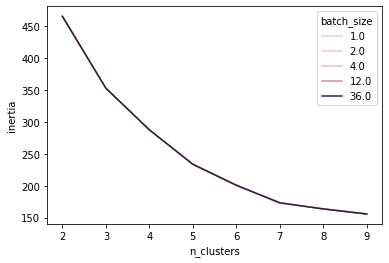

In [10]:
from sklearn.cluster import MiniBatchKMeans

n_cluster_candidates = list(range(2, 10))
bkmeans_sets = pd.DataFrame(columns=["n_clusters", "batch_size", "inertia"])

for n_clusters in n_cluster_candidates:
    for batch_size in [1,2,4, 12, 36]:
        bkm = MiniBatchKMeans(
            n_clusters=n_clusters,
            random_state=19,
        )
        bkm.fit(base_shifted_data)
        bkmeans_sets = bkmeans_sets.append({"batch_size": batch_size, "n_clusters": n_clusters, "inertia": bkm.inertia_}, ignore_index=True)

        

sbs.lineplot(data=bkmeans_sets, x="n_clusters", y="inertia", hue="batch_size")

In this case, the best k would be between 6 and 8, as in the previous one.

With the MiniBatchKMeans, we also decided to change the batch size used by the algorithm, and study its effect on the score. The batch size didn't make any difference (using the Elbow's method). 

This technique is usually used for larger datasets, and executes faster. On the other hand, when compared to the previous clustering technique, it usually gets slightly worse results. 

In [11]:
# By the elbow rule, any number of clusters between 5 and 7, inclusive
# should give us an aproximately optimal number of clusters
# There is no meaningful difference between the batch sizes
bkm = MiniBatchKMeans(n_clusters=7, random_state=19, batch_size=36)
bkm.fit(base_shifted_data)
bkmeans_clusters = bkm.predict(base_shifted_data)

<AxesSubplot:xlabel='eps', ylabel='silhouette_score'>

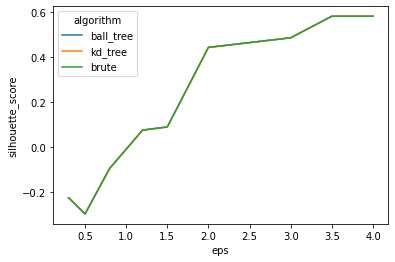

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
dbscans = pd.DataFrame(columns=["eps", "algorithm", "sill_coef"])

for eps in [0.3, 0.5, 0.8, 1.2, 1.5, 2, 3, 3.5, 4]:
    for algorithm in ["ball_tree", "kd_tree", "brute"]:
        dbs = DBSCAN(
            eps = eps,
            min_samples=2,
            algorithm=algorithm,
        )
        labels = dbs.fit_predict(base_shifted_data)
        sil = silhouette_score(X=base_shifted_data, labels=labels)
        dbscans = dbscans.append({"eps": eps, "algorithm": algorithm, "silhouette_score": sil}, ignore_index=True)

sbs.lineplot(data=dbscans, x="eps", y="silhouette_score", hue="algorithm")

 Silhouette Coefficient

* Average silhouette coefficients that are negative, is usually an indication that the cluster allocation is wrong.

* Average silhouette coefficients that are close to zero indicate that there is no well defined cluster.

* The larger the average silhouette values (max. 1), the better.


The results we got using DBSCAN seem to be inconclusive, because although the the score gets better as the eps value grows, the number of cluster is also being reduced, until it reaches 1 (If eps = 4.5, the number of labels returned would be 1), which isn't helpful for our analysis.

<AxesSubplot:xlabel='n_clusters', ylabel='silhouette_score'>

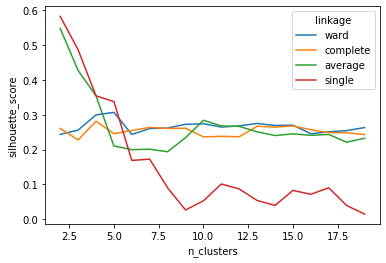

In [29]:
from sklearn.cluster import AgglomerativeClustering

aggr_clusters = pd.DataFrame(columns=["silhouette_score", "linkage", "n_clusters"])

for n_clusters in range(2, 20):
    for linkage in ["ward", "complete", "average", "single"]:
        ag = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage,
        )
        labels = ag.fit_predict(base_shifted_data)
        sil = silhouette_score(base_shifted_data,labels)
        aggr_clusters = aggr_clusters.append({"linkage": linkage, "n_clusters": n_clusters, "silhouette_score": sil}, ignore_index=True)

        

sbs.lineplot(data=aggr_clusters, x="n_clusters", y="silhouette_score", hue="linkage")

The results we got using Agglomerative Clustering seem to be reasonable in most cases.
The majority of the linkage methods scores are in the interval [0.2, 0.35], which tells us that the clusters assignment isn't wrong, but it could be better (if closer to 1).
It's also worth noting that the 'single' linkage method, tends to get worse score as the number of clusters increases.